## Afternoon practical day 5

Welcome to the final practical of today. We'll do a few things:
* Use K-means clustering to reduce the dimensionality of images (compression)
* Use PCA to get some insight into a high-dimensional dataset
* Use PCA together with linear regression to get a more proper GWAS




In [73]:
#run this cell to set things up
import ipywidgets as widgets, numpy as np, pandas as pd
from numpy.random import default_rng
%matplotlib notebook
import matplotlib.pyplot as plt
import math
import random
import seaborn as sns
from IPython.display import display, Markdown
from scipy.optimize import fmin_bfgs, fmin_cg, fmin
import sklearn
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
import itertools
import xarray
import scipy
from pandas_plink import read_plink1_bin

In [112]:
# important functions

def calcEucliDist(vectorOne, vectorTwo):
    return np.linalg.norm(vectorOne-vectorTwo, axis = 1)

def calcAbsDist(vectorOne, vectorTwo):
    #using linalg.norm:
    return np.linalg.norm(vectorOne-vectorTwo, ord = 1, axis = 1)

def makeKMeanClusters(X, k, funName = "calcEucliDist", maxIter = 50, nClusteringsToPerform = 20):
    if k <= 0:
        print("K must be greater than 0!")
        return None
    if k > len(X):
        print("K cannot be larger than the # of samples in your data!")
        return None
    if maxIter <= 0:
        print("Cannot have negative or 0 iterations!")
        return None
    
    resultToReturn = [None, None, None, None]
    bestDistortion = np.Inf
    
    for clusteringIndex in range(0, nClusteringsToPerform):
        print("Random initialisation: " + str(clusteringIndex+1))
        initialCentroids   = X[np.random.choice(X.shape[0], k, replace=False), :]
        if len(initialCentroids) != k:
            print("Centroids lost!")
        centroids          = initialCentroids
        threeLastCentroids = []
        #print(centroids)
        for i in range(0, maxIter):
            print("iteration " + str(i+1))

            threeLastCentroids.append(np.round(centroids, 4))
            distancesToCentroids = np.vstack([globals()[funName](centroids, datapoint) for datapoint in X])

            #could be equidistant from two centroids. Then need to choose. So:
            closestCentroidsPerDataPoint      = distancesToCentroids == np.amin(distancesToCentroids,
                                                                            axis = 1)[:, np.newaxis]
            # this checks for every row whether there's >1 cluster to which you are closest.
            # if so, just assign to 1 of those randomly, and remove the other.
            for index, row in enumerate(closestCentroidsPerDataPoint):
                if np.sum(row) > 1:
                    coords = np.where(row == True)[0]
                    #print(coords)
                    randomChoiceAssignCentroid = np.random.choice(coords, replace = False)
                    closestCentroidsPerDataPoint[index,0:len(row)] = False
                    closestCentroidsPerDataPoint[index,randomChoiceAssignCentroid] = True
            closestCentroid = np.where(closestCentroidsPerDataPoint)[1]

            centroids            = np.vstack([np.mean(X[np.where(closestCentroid == clusterNum)],
                                                      axis = 0) for clusterNum in np.unique(closestCentroid)])

            if i >2:
                threeLastCentroids.pop(0)
                if np.array_equal(threeLastCentroids[-1],threeLastCentroids[-2]) and np.array_equal(threeLastCentroids[-2], threeLastCentroids[-3]):
                    print("No changes in cluster centroids detected in last 3 iterations. Finished at iteration " + str(i+1) + ".")
                    break
        
        # new code
        squareDistancesPerPoint = []
        for index, centroid in enumerate(closestCentroid):
            squareDistancesPerPoint.append(np.square(centroids[centroid, :] - X[index, :]))
        distortion = 1/len(X) * np.sum(np.array(squareDistancesPerPoint))
        
        if distortion < bestDistortion:
            bestDistortion = distortion
            resultToReturn = [centroids, closestCentroid, initialCentroids, bestDistortion]
                
    return resultToReturn

def hierarCluster(X, distanceFunc = "calcEucliDist", linkageMethod = "average", displayDistMatrix = False):
    
    if linkageMethod not in ["average", "complete", "single"]:
        print("Error, please input a valid linkage method!")
        return None
    if distanceFunc  not in globals().keys():
        print("Error, please input a valid distance function name!")
    
    # make an empty distance matrix
    distanceMatrix = np.zeros(shape = (len(X), len(X)))
    distanceMatrix.fill(np.nan)
    # make a list with the indices of every data point. This is the list of clusters, where you start
    # with every point in a cluster and then start merging them.
    initialList = [[index] for index, _ in enumerate(X)]
    clusterList = initialList.copy()
    clusteringOverIterations = []
    clusteringOverIterations.append(initialList)
    # also make an empty list that saves which cluster indices were merged for every iteration
    clusterIndicesMergedList = []
    for rowIndex, row in enumerate(distanceMatrix):
        for colIndex, cellValue in enumerate(row):
            # distance from yourself to yourself is 0, don't calculate!
            if colIndex == rowIndex:
                continue
            # in the first loop, you calculate distance from 1 to 2.
            # in the second loop, you don't want to calculate distance from 2 to 1 again. This safeguards against that.
            if colIndex < rowIndex:
                continue

            distanceMatrix[rowIndex, colIndex] = globals()[distanceFunc](X[rowIndex,:][np.newaxis,  :],
                                                                             X[colIndex, :][np.newaxis, :])
    if displayDistMatrix:
        display(pd.DataFrame(distanceMatrix))

    # We continue clustering until everything is in one giant cluster. Thats len(X)-1 clustering steps.
    for i in range(0, len(X)-1):
        # we start with no idea of which two clusters we need to cluster
        lowestDistDatapoints = None
        # since we haven't calculated any distance, our current distance is infinite
        distToCluster = np.Inf
        # clusterList initially looks like [[0], [1], ... [99]].
        # itertools.combinations makes that into [([0], [1]), ([0], [2]), ([0], [3]) ... ([1], [2]), ([1], [3])... (98, 99)]
        # so you get all possible combinations of clusters that you could cluster together
        for combo in itertools.combinations(clusterList, 2):

            distance = 0
            distanceSingleLink = np.Inf # need this because for single linkage you want lowest distance to be selected
                                        # so need to have the starting distance always be lower.
            # make all combinations of data points in the first cluster and data points in the second cluster
            # so if the current combo = ([0, 12, 15], [3, 2]), this results in:
            # [[0, 3], [0, 2], [12, 3], [12, 2], [15, 3], [15,2]]: these are all the points that we need to get
            # the distances for (and average for average linkage)
            toIterate = [j for i in [list(zip([elem] * len(combo[1]), combo[1] )) for elem in combo[0]] for j in i]
            for indicesTwoDatapoints in toIterate:
                #sort the indices. Our matrix has only the distance between 1 and 2, not between 2 and 1.
                #this turns [12, 2] from above into [2, 12], etc.
                indicesTwoDatapoints = sorted(indicesTwoDatapoints)

                # keep a running total of all distances between the points in the two clusters
                if linkageMethod == "average":
                    distance += distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]]
                if linkageMethod == "complete":
                    # for a cluster, if the distance between two points is larger than the current largest distance
                    # between points in a cluster, that is the new cluster distance.
                    if distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]] > distance:
                        distance = distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]]
                if linkageMethod == "single":
                    if distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]] < distanceSingleLink:
                        distanceSingleLink = distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]]

            if linkageMethod == "average":
                totalAvgDistance = distance/(len(combo[0]) * len(combo[1]))

            # if distance between these clusters is less than the lowest distance we have seen so far,
            #set these clusters as the ones to cluster. 
                if totalAvgDistance < distToCluster:
                    distToCluster       = totalAvgDistance
                    dataPointsToCluster = combo

            if linkageMethod == "complete":
                if distance < distToCluster:
                    distToCluster       = distance
                    dataPointsToCluster = combo

            if linkageMethod == "single":
                if distanceSingleLink < distToCluster:
                    distToCluster       = distanceSingleLink
                    dataPointsToCluster = combo

        #make a new list of clusters
        clusterIndicesMergedList.append(dataPointsToCluster)
        clusterList = clusterList.copy()
        for index, elem in enumerate(clusterList):
            # merge the second cluster into the first cluster
            if elem == dataPointsToCluster[0]:
                clusterList[index] = clusterList[index] + dataPointsToCluster[1]
                #clusterList2[index] = sorted(clusterList[index])
            # remove the separate second cluster (it's now been merged to the first one)    
            if elem == dataPointsToCluster[1]:
                clusterList.pop(index)
        # Finally, save all clusters, from the very beginning (all separate clusters) until the very end (all in one cluster) in one list by appending to that the current clusters      
        clusteringOverIterations.append(clusterList)
        
        #addition to make a list of lists of everything:
        
    
    return [clusteringOverIterations, pd.DataFrame(distanceMatrix), clusterIndicesMergedList]


def drawHierarchicalClustering(hierarClusterOutcome, figsize = (25,8), title = "Plot", labels = None):
    clusterListX       = hierarClusterOutcome[0]
    clusteredPerStepX  = hierarClusterOutcome[2]
    xLabels            = np.array(list(itertools.chain(*clusterListX[-1])))
    
    fig, ax = plt.subplots(figsize = figsize)
    ax.set_xticks(range(0, len(xLabels)))
    if not labels is None:
        labels = np.array(labels)
        if len(labels) == len(xLabels):
            labels = labels[xLabels]
            ax.set_xticklabels(labels, rotation = 90)      
        else:
            print("Labels supplied should be of same length as the amount of data points!")
            return None
    else:   
        ax.set_xticklabels(xLabels)
    ax.margins(y=0)

    heightPerDataPointPreviousStep = np.array([0] * len(xLabels))
    for i, clusterStep in enumerate(clusteredPerStepX):
        pos1Positions = np.array([np.where(xLabels == elem)[0] for elem in clusterStep[0]])
        pos1Avg       = np.mean(pos1Positions)
        #pos1Start     = np.min(pos1Positions)
        #pos1End       = np.max(pos1Positions)
        pos1ClustSize = len(pos1Positions)
        pos2Positions = np.array([np.where(xLabels == elem)[0] for elem in clusterStep[1]])
        pos2Avg       = np.mean(pos2Positions)
        #pos2Start     = np.min(pos2Positions)
        #pos2End       = np.max(pos2Positions)
        pos2ClustSize = len(pos2Positions)



        heightEnd   = max(pos1ClustSize, pos2ClustSize)
        ax.plot([pos1Avg, pos1Avg], [heightPerDataPointPreviousStep[pos1Positions[0][0]],heightEnd], color = "black")
        ax.plot([pos2Avg, pos2Avg], [heightPerDataPointPreviousStep[pos2Positions[0][0]],heightEnd], color = "black")
        ax.plot([pos1Avg, pos2Avg], [heightEnd,heightEnd], color = "black")

        heightPerDataPointPreviousStep[np.ravel(pos1Positions)] += heightEnd - heightPerDataPointPreviousStep[pos1Positions[0][0]]
        heightPerDataPointPreviousStep[np.ravel(pos2Positions)] += heightEnd - heightPerDataPointPreviousStep[pos2Positions[0][0]]

    ax.set_ylim(0, max(heightPerDataPointPreviousStep)+1)
    fig.suptitle(title)

    plt.show(fig)
    
    
def linAlgRegHypothesis(data, thetas):
    #print(thetas)
    data = np.array(data)
    oneFeatToAdd = np.ones(len(data))
    newFeatArray = np.c_[oneFeatToAdd, data]
    predictions = newFeatArray @ thetas
    return predictions

def linAlgGradientDescent(x, y, thetas, alpha) :
    m = len(x)
    if thetas.ndim != 2:
        thetas = thetas[:, np.newaxis]
    preds  = linAlgRegHypothesis(x, thetas)
    if preds.shape != (m, 1):
        preds  = preds[:, np.newaxis]
    if y.ndim != 2:
        y = y[:, np.newaxis]
    errors = preds - y
    gradientSummation  = errors.T @ np.c_[np.ones(len(errors)), x]
    finalGradientSteps = alpha/m * gradientSummation
    newThetas          = thetas - finalGradientSteps.T
    
    return newThetas



## K-means for image compression

It is not so that dimension reduction and clustering are entirely unrelated. If you have 100 samples with 10 features each, and you believe (after the iterative clustering workflow) that you can really cluster the data clearly into, say, 3 clusters, then you can use the cluster centroids to represent the data and in principle can thus compress the differences you are interested in into these three clusters.

A nice visual way of looking at this is image compression using K-means clustering. Pixels in images all have 3 features, their R, G and B values, which normally range between 0 and 255 inclusive. If we cluster all these pixels into, say, 32 clusters, we can then replace each pixel with the value of the centroid of the cluster it belongs to. This can really compress an image while still showing the most important features. 

Below, I load in an image of a cat, show it, and show a 3D plot of (some of the >3 million) pixel values. Go to the next cell to read what you need to do.

<IPython.core.display.Javascript object>


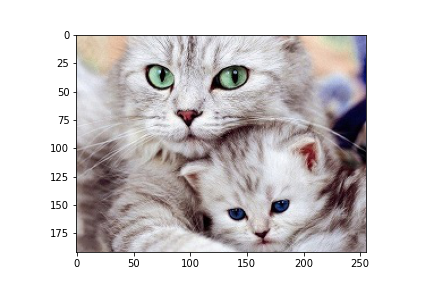

<IPython.core.display.Javascript object>


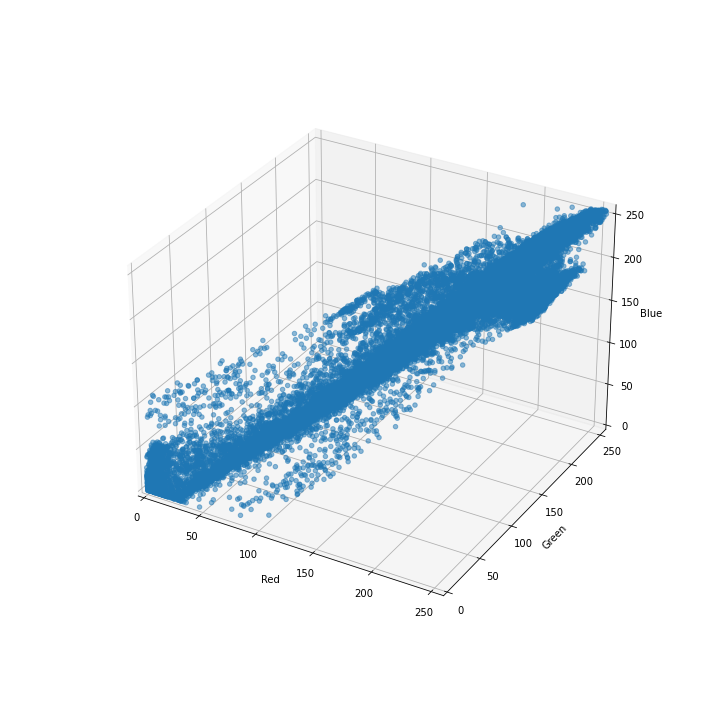

In [88]:
catPic = plt.imread("CatImage.jpg")
plt.imshow(catPic)

rValues = np.ravel(catPic[:,:,0])[:,np.newaxis]
gValues = np.ravel(catPic[:,:,1])[:,np.newaxis]
bValues = np.ravel(catPic[:,:,2])[:,np.newaxis]
featMatCat = np.hstack([rValues, gValues, bValues])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
random.seed(42)
indicesToPlot = random.sample(range(0,len(featMatCat)), len(featMatCat))
ax.scatter(featMatCat[indicesToPlot,0], featMatCat[indicesToPlot,1], featMatCat[indicesToPlot,2], alpha = 0.5)
ax.set_xlabel("Red"); ax.set_xlim((0,255))
ax.set_ylabel("Green"); ax.set_ylim((0,255))
ax.set_zlabel("Blue"); ax.set_zlim((0,255))
fig.show()

## Doing compression with K-means
Okay, now it's up to you to:
* Perform K-means clustering on the data, using K = 32, and using K = 16. I recommend you use sklearn's implementation: `KMeans`(see [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)). I did it with our own K-means implementation, but that really drove home the point of how K-means for large datasets requires 1. a _very_ efficient implementation and 2. a smart way of picking the initial centroids. Otherwise it takes a **_long_** time. Don't do what I did, use sklearn!
* Make a new `featMatCat` (call it whatever you want). Here, replace each pixel value with the value of its closest centroid.
* Now, [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html#) this new matrix in the shape of `catPic`. 
* Then, use `np.round(yourMatrix).astype(int)`. This makes sure you get integers between 0-255. The centroid coordinates are often floats, but a pixel intensity of 55.675 is not defined, for instance!
* Finally, use `plt.imshow()` and `plt.show()` to show the compressed picture.

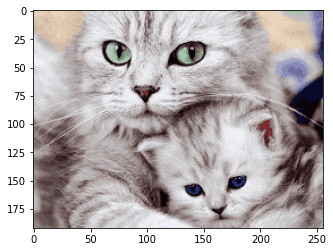

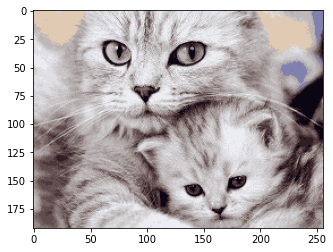

In [143]:
%matplotlib inline
# your answer here

# answer 
# KMeansOutcome32 = makeKMeanClusters(featMatCat, 32, funName = "calcEucliDist", maxIter = 20, nClusteringsToPerform = 5)
# KMeansOutcome16 = makeKMeanClusters(featMatCat, 16, funName = "calcEucliDist", maxIter = 20, nClusteringsToPerform = 5)
kMeans16          = KMeans(n_clusters = 16).fit(featMatCat)
kMeans32          = KMeans(n_clusters = 32).fit(featMatCat)
featMatCat32      = kMeans32.cluster_centers_[kMeans32.labels_, :]
reshapedFeatMat32 = np.reshape(featMatCat32, catPic.shape)
plt.imshow(np.round(reshapedFeatMat32).astype(int))
plt.show()
featMatCat16      = kMeans16.cluster_centers_[kMeans16.labels_, :]
reshapedFeatMat16 = np.reshape(featMatCat16, catPic.shape)
plt.imshow(np.round(reshapedFeatMat16).astype(int))

## What you see
If all goes well, you'll see that the image becomes more gray, and the background colours become more blurry and chaotic, but that otherwise much of the detail is kept. If you were to save this to disk, you'd need a dictionary with the 16 or 32 centroid values, and then each pixel would just refer to one of those values. That could change the file size by a factor ~6 for the 16 colour case, which is pretty nice if you want to store thousands of images. You can probably imagine that, nevermind the compression, if we want to train a neural network to differentiate between cats and dogs, images compressed like this would still be plenty good enough to train it. But you'd have 6 times less disk space usage!

## Functionalising PCA and projecting back

In the morning practical you got some familiarity with PCA. Now, let's implement it as a function ourselves, and also project data points back from the reduced PCA space to the original space. We won't be using svd, just `np.linalg.eig`.
Up to you to:
* Define a function called `doPCA` that takes in a **normalised** data matrix.
* Have it calculate the covariance matrix using $X^T \cdot X$
* It should return a list of 1. ordered eigenvalues (high to low), 2. ordered eigenvectors (in the order of the eigenvalues) and 3. The PCA projection of that data matrix, without reducing the dimensions (so just the rotation of the full space, i.e. all the PCs). 
* Test it on X supplied below.
* Plot a 3D scatterplot of the original data and the PCA data.

Hints:
* For 3D plotting, just copy the code from above and change it.
* Use the `argsort` trick from the short practical to sort correctly.

<IPython.core.display.Javascript object>


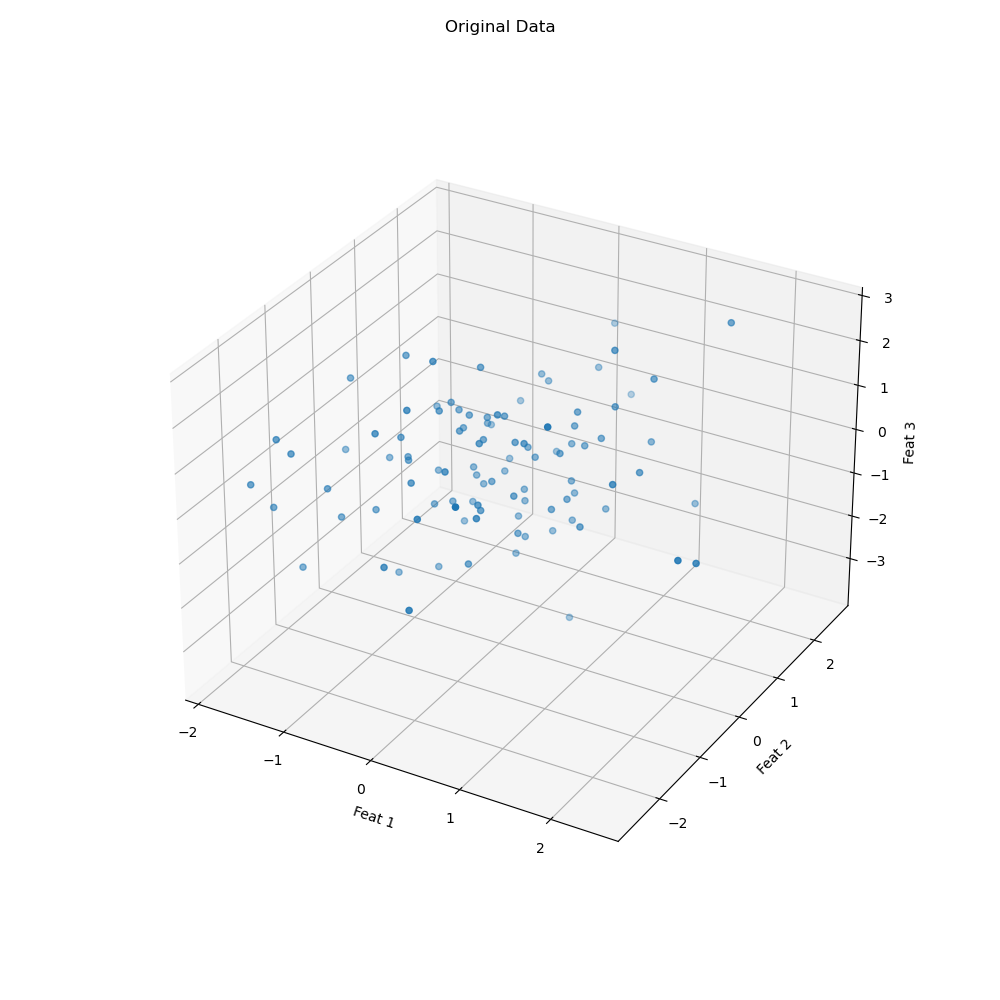

<IPython.core.display.Javascript object>


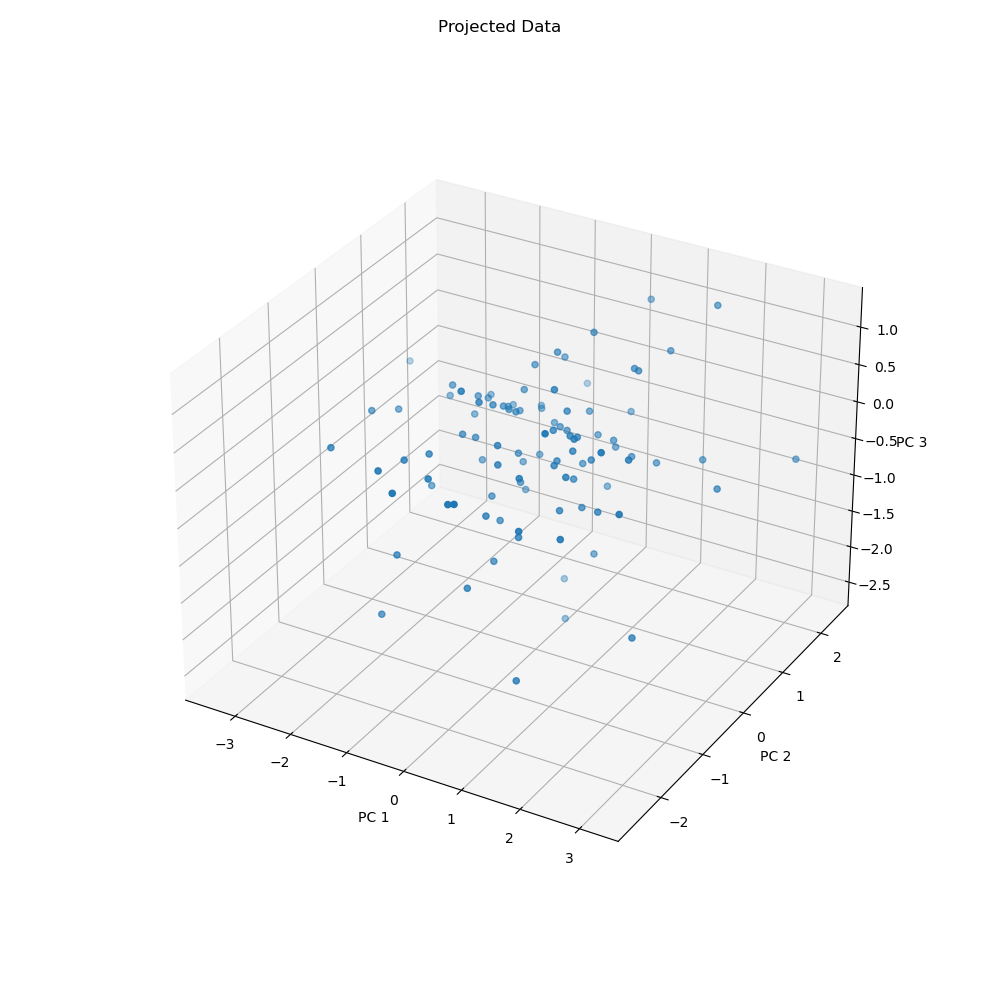

In [61]:
%matplotlib notebook
X, y = make_classification(n_samples = 100, n_features = 3, n_informative = 2,
                           n_redundant = 0, n_classes = 2, hypercube = False, random_state=42)
XStd  = np.std(X)
XMean = np.mean(X)
XNorm = (X-XMean)/XStd
# your answer here


# answer
def doPCA(XNorm):
    # check that this is really mean-centered data
    np.testing.assert_almost_equal(np.mean(XNorm), np.array([0]*np.shape(XNorm)[1]), decimal=2, err_msg='Data should be mean-centered!', verbose=True)
    covMat = XNorm.T @ XNorm
    eigenvalues, eigenvectors = np.linalg.eig(covMat)
    ##this (arg)sorts in descending order. See: https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order 
    indicesForSorting = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[indicesForSorting]; eigenvectors = eigenvectors[:,indicesForSorting]
    
    projectedData = XNorm @ eigenvectors
    return [eigenvalues, eigenvectors, projectedData]

eigVals, eigVecs, projData = doPCA(XNorm)

#making a 3D plot

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
fig.suptitle("Original Data")
ax.scatter(XNorm[:,0], XNorm[:,1], XNorm[:,2])
ax.set_xlabel("Feat 1")
ax.set_ylabel("Feat 2")
ax.set_zlabel("Feat 3")
fig.show()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
fig.suptitle("Projected Data")
ax.scatter(projData[:,0], projData[:,1], projData[:,2])
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
fig.show()


## Projecting back and reducing the dimensionality

What you might see in the 3D plots is...that you can't quite know whether this is the same data. It is, but you can't see it.

We'd like to be able to go back from the PCA projection to the original data. If you keep all the PCs, then of course the data you get back is exactly the same: all you've done is rotated the data, making new axes that follow a certain recipe of linear combinations of the old axes. If you've reduced the dimensions, then there will be errors: you removed dimensions along which there can be variance. In the 3D case here, you map from 3D to a 2D plane, and if you try to map back to 3D then..well..there's no variation along the 3rd dimension in your reconstruction, while there might have been some in the actual data.

The idea, or goal in reality of course is that, while yes, you may lose 5% of the variance, if that allows you to remove 50 of 100 dimensions, that's a _pretty darn good_ deal. So, let's get to it. You need to make two functions:

1. `dimReducePCA()` which takes in `projectedData`, `eigenvectors`, and `nDims`, and returns only the nDims first dimensions from the projected data, and the first nDims eigenvectors (PC recipes) corresponding to it.

2. `reconstructPCA()` which takes in `projectedData` and `eigenVectors`, and returns $(eigenVectors \cdot projectedData^T)^T$. This gives you back your original coordinates. Note: this is linear algebra, so use @.

* Finally, run `reconstructPCA` on the unaltered output features from your `doPCA` function. Check that the output is equal to `XNorm` using `numpy.allclose` [click](https://numpy.org/doc/stable/reference/generated/numpy.allclose.html).

In [62]:
# your answer here


# answer
def dimReducePCA(projectedData, eigenVectors, nDims):
    if nDims <= 0: 
        print("Error: should select at least 1 dimension!")
        return None
    
    return [projectedData[:,0:nDims], eigenVectors[:,0:nDims]]

def reconstructPCA(projectedData, eigenVectors):
    return (eigenVectors @ projectedData.T).T


print(np.allclose(reconstructPCA(projData, eigVecs), XNorm))
# print(reconstructPCA(projData, eigVecs))
# print(XNorm)

True


## Reconstructing from 2D and 1D

So how are we doing when we actually do what we want to use PCA for: reducing dimensions? Let's (visually) find out!
* Use `dimReducePCA` with `nDims=2` on the output of your `doPCA` function.
* Then, perform `reconstructPCA` on this reduced data.
* Finally, plot a 3D plot with the original data in blue, and the reconstructed data in red. Visually, how are you doing?
* Do the same for dimension reduction for just one dimension, and plot these points in orange.

Hints:
* If you are confused about this reconstruction magic, read [this](https://stats.stackexchange.com/a/229093).
* Again, copy the 3D-plotting code from above, just add a second call to `ax.scatter`.

<IPython.core.display.Javascript object>


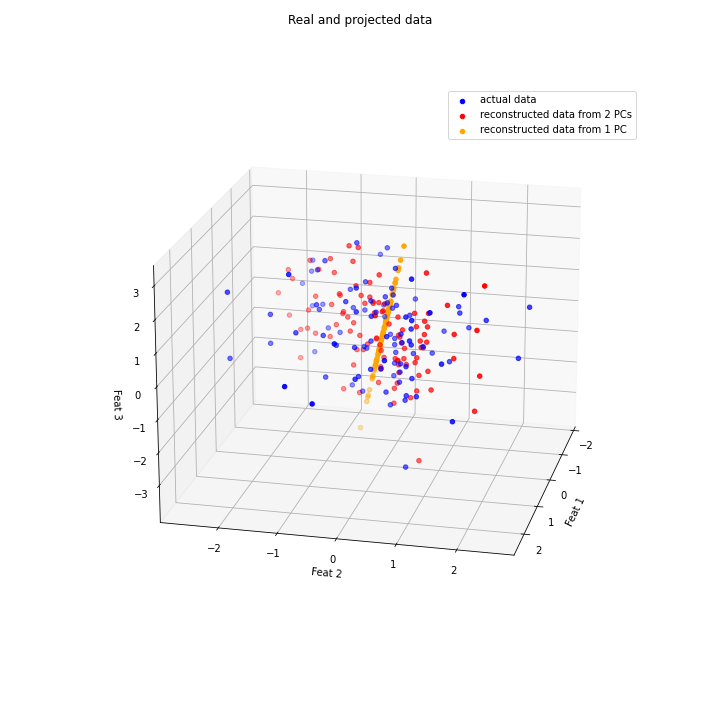

In [186]:
# your answer here


# answer
projDataReduce, eigVecsReduce = dimReducePCA(projData, eigVecs, nDims = 2)
reconstruct2D = reconstructPCA(projDataReduce, eigVecsReduce)

projDataReduce1D, eigVecsReduce1D = dimReducePCA(projData, eigVecs, nDims = 1)
reconstruct1D = reconstructPCA(projDataReduce1D, eigVecsReduce1D)

#plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
fig.suptitle("Real and projected data")
ax.scatter(XNorm[:,0], XNorm[:,1], XNorm[:,2], c = "blue", label = "actual data")
ax.scatter(reconstruct2D[:,0], reconstruct2D[:,1], reconstruct2D[:,2], c = "red", label = "reconstructed data from 2 PCs")
ax.scatter(reconstruct1D[:,0], reconstruct1D[:,1], reconstruct1D[:,2], c = "orange", label = "reconstructed data from 1 PC")
ax.set_xlabel("Feat 1")
ax.set_ylabel("Feat 2")
ax.set_zlabel("Feat 3")
ax.legend()
fig.show()

## What you'll see

You'll see that the red points you make all lie on a 2D hyperplane within the space. This is logical: we removed a PC from the data, so we can't get that third dimension back. If we look at this hyperplane from the side, it should look something like this: ![example](exampleDimRed.png).
With 1D projection included, you get this, with a line through the 3D space: ![example2](exampleDimRed2.png)

## What we want
With this knowledge, we can think about what we want from our PCA. We want a compression into fewer dimensions that keeps as much of the variation as possible. For each of the reconstructed points, we can calculate how wrong it is: this is just the sum of square (Euclidean) distances. So the average error of all the reconstructed points is:
$$\frac{1}{m}\cdot \sum_{i=1}^m||x^{(i)}-x^{(i)}_{reconstructed}||^2$$

The total variance in the data is just the average of the sum of the distance from each point to zero:
$$\frac{1}{m}\cdot \sum_{i=1}^m||x^{(i)}||^2$$

Usually we say something like: 'we want to keep 90% of the variance in the data'. So what does that translate to? Well, the reconstruction error _is_ the part of the variance that you now no longer capture: it's the variance you have lost because you have reduced your dimensions. So if you want to keep 90% of the variance, that comes out to:
$$\frac{\frac{1}{m}\cdot \sum_{i=1}^m||x^{(i)}-x^{(i)}_{reconstructed}||^2}{\frac{1}{m}\cdot \sum_{i=1}^m||x^{(i)}||^2} <= 0.10$$ Or in words: I want to choose my # of dimensions to keep _k_, _such that_ I don't lose more than 10% of the variance.

Written like this, it seems like you'd have to calculate this quantity for every k, until the criterion is satisfied. Luckily for us, and as you know, this is not the case. We can simply divide the eigenvalue for a principal component (eigenvector) by the sum of eigenvalues. Then we cumulatively sum the %variance explained and choose the #PCs k such that it's >= 90%.

In the code cell below, calculate the cumulative % variance explained by the 3 PCs in this sample data. [Hint](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html).

In [188]:
eigVals, eigVecs, projData = doPCA(XNorm)
# your answer here

# answer
eigValTotal = np.sum(eigVals)
varianceExpPerPC = [elem/eigValTotal*100 for elem in eigVals]
np.cumsum(varianceExpPerPC)

array([ 44.40284412,  84.05806097, 100.        ])

## Application of PCA to ecological data

Now, let's apply PCA to some ecological data. Below, I load in data describing vegetation plots in an Alpine location. See [here](https://www.davidzeleny.net/anadat-r/doku.php/en:data:aravo) for more info, if you want. Now, in these vegetation plots, many different species of plant can be present. As well, certain characteristics of the plot are logged: day of snowfall and incline, for instance.

It is up to you to:
* Do PCA on the data (don't forget to normalise!)
* Plot the 2D reconstruction of the data, complete with variance explained on each PC.
* Deduce which factors explain most of the variance in this data. For this, look into the eigenvectors of PC1 and PC2: the absolute max element(s) of these eigenvectors are apparently the variables in the original data that most contribute to the separation of these datapoints along these axes! For our purposes here, take the 2 largest values (negative or positive) in each eigenvector and see what this tells you.

Hints:
* If you want np.arrays, use `np.array(df.to_numpy(), np.float64)`. To get columns: `df.columns`. To get the sample names, use `df.iloc[:,0]`
* If you want to exclude the column with plot names, use something like `df.iloc[:,1:]`.
* If you can't crack how to look in the eigenvectors for the maximum absolute elements, then look in the answers.

,Unnamed: 0,Agro.rupe,Alop.alpi,Anth.nipp,Heli.sede,Aven.vers,Care.rosa,Care.foet,Care.parv,Care.rupe,...,Oxyt.camp,Oxyt.lapp,Lotu.alpi,Trif.alpi,Trif.badi,Trif.thal,Aspect,Slope,PhysD,Snow
0,AR07,1,1,1,1,1,2,1,1,4,...,2,2,1,1,1,1,8,3,51,141
1,AR71,1,1,1,1,1,3,1,2,1,...,1,2,1,1,1,1,2,36,41,141
2,AR26,4,1,2,1,2,3,1,1,1,...,2,1,1,1,1,1,6,1,21,141
3,AR54,1,1,1,3,1,3,1,1,1,...,1,2,1,1,1,1,10,31,81,141
4,AR60,1,1,1,1,1,1,1,1,1,...,1,2,1,1,1,1,10,6,81,141


<IPython.core.display.Javascript object>


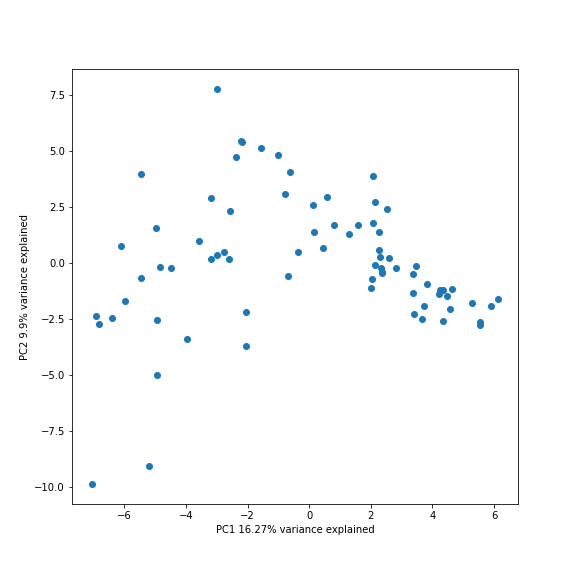

PC1
Snow : 0.22665425066325587
Kobr.myos : -0.20005433762511735
PC2
Geum.mont : 0.23269482042336895
Pote.aure : 0.22523209138562758


In [230]:
ecoData = pd.read_csv('EcologicalData.csv')
# I need to remove the many 0 entries, otherwise the matrix becomes noninvertible and you get complex eigenvectors
# Don't concern yourself with this further! However, it goes to show that PCA doesn't like sparse matrices. For that
# you need sparse PCA. Won't go into that here. See: https://medium.com/principal-component-analysis-on-a-high-dimensional/https-medium-com-pcasparsematrix-545d18efff0a 
ecoData.iloc[:,1:] = ecoData.iloc[:,1:] +1
display(ecoData.head())

#your answer here

values = np.array(ecoData.to_numpy()[:,1:], np.float64)
means  = np.mean(values, axis = 0)
std    = np.std(values, axis = 0)

valNorm = (values-means)/std
eigValsEco, eigVecsEco, projDataEco = doPCA(valNorm)
dimRedProjDataEco, dimRedEigVecsEco = dimReducePCA(projDataEco, eigVecsEco, nDims = 2)

fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(dimRedProjDataEco[:,0], dimRedProjDataEco[:,1])
xVar = eigValsEco[0]/np.sum(eigValsEco)*100
yVar = eigValsEco[1]/np.sum(eigValsEco)*100
ax.set_xlabel("PC1 " + str(np.round(xVar,2)) + "% variance explained")
ax.set_ylabel("PC2 " + str(np.round(yVar, 2)) + '% variance explained')
fig.show()

# loop over the eigenvectors, which are the columns.
for i in range(0, dimRedEigVecsEco.shape[1]):
    eigVec         = dimRedEigVecsEco[:,i]
    sorting        = np.argsort(np.abs(eigVec))[::-1]
    maxOneIndex    = sorting[0]
    maxOneName     = ecoData.iloc[:, 1:].columns[maxOneIndex]
    maxOneValue    = eigVec[maxOneIndex]
    secondMaxIndex = sorting[1]
    secondMaxName  = ecoData.iloc[:, 1:].columns[secondMaxIndex]
    secondMaxValue = eigVec[secondMaxIndex]
    print("PC" + str(i+1))
    print(maxOneName + " : " + str(maxOneValue))
    print(secondMaxName + " : " + str(secondMaxValue))

## Outcome

If all goes well, you should see that PC1 mainly concerns itself with the day of snow melting and a plant called Kobresia myosuroides (Vill.) Fiori, which looks like this: ![image](Kobresia.jpg).

PC2 concerns itself with Geum montanum L. and Potentilla aurea L. The upshot here is that the eigenvectors are not just 'things you need to use to project the data to lower dimensions', but that these recipes to make the new linear combinations can tell you things. In a gene expression context, they could show you the genes whose expressions vary most among your experimental conditions (and which might thus be related), in behavioural contexts you could see in what (combinations) of behaviours chimpanzees differ most from each other, etc. The loadings (eigenvectors) are an important part of getting insight from PCA.

Note that, for this data, the 2 axes certainly don't capture that much of the variance so you'd want a lot more PCs in actual data for ML.

## A close relative of PCA: MDS

Before we move on to applying PCA in a GWAS, I want to introduce you to a close relative of PCA that we could now also easily implement. PCA works on the covariance matrix: it says how features/dimensions in your data vary by themselves (their spread) on the diagonal, and how they vary with others (all off-diagonal entries). Multi-dimensional scaling (MDS) works on a distance matrix. Other than that, it is **exactly the same**. So, just like PCA, you take the distance matrix, and calculate eigenvalues and eigenvectors, and project down to fewer dimensions. Thus, whereas PCA makes new linear combinations of the old dimensions, where every dimension has the maximum of variance and is not correlated with each other PCA axis, so MDS works on a _distance matrix_ and tries to preserve high-dimensional distances in lower-dimensional space. It works linearly, however, unlike the graph-based and highly impressive UMAP. It turns out that **for Euclidian distance, PCA and MDS are the same**. But for other distance measures, they are distinct.

* Watch the end of [this video by StatQuest](https://youtu.be/GEn-_dAyYME?t=409)
* Read the beginning of [this Wikipedia article](https://en.wikipedia.org/wiki/Multidimensional_scaling) (i.e. only the introduction).



## When to use what

So why would you use PCA or MDS? Well, PCA gives you uncorrelated dimensions that capture most of the variance, and works on the covariance matrix. MDS works on the basis of pairwise distances, and tries to make a geometric embedding such that these distances are preserved. We'll do PCA and MDS on some spatial data, specifically, European cities and their coordinates. Below, I perform MDS. Your job is to perform PCA on the data and compare. Up to you to:

* Take the 2 features (latitude and longitude) and perform PCA on them and plot the cities in these new dimensions.
* As labels of the points, use the city names. Use `ax.annotate` [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.annotate.html?highlight=annotate#matplotlib.axes.Axes.annotate) instead of `ax.scatter`.



,city,country,latitude,longitude,temperature
0,Aalborg,Denmark,57.03,9.92,7.52
1,Aberdeen,United Kingdom,57.17,-2.08,8.10
2,Abisko,Sweden,63.35,18.83,0.20
3,Adana,Turkey,36.99,35.32,18.67
4,Albacete,Spain,39.00,-1.87,12.62


<ipython-input-307-fffbd1a723b2>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-307-fffbd1a723b2>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Text(0.5, 0.98, 'PCA plot')

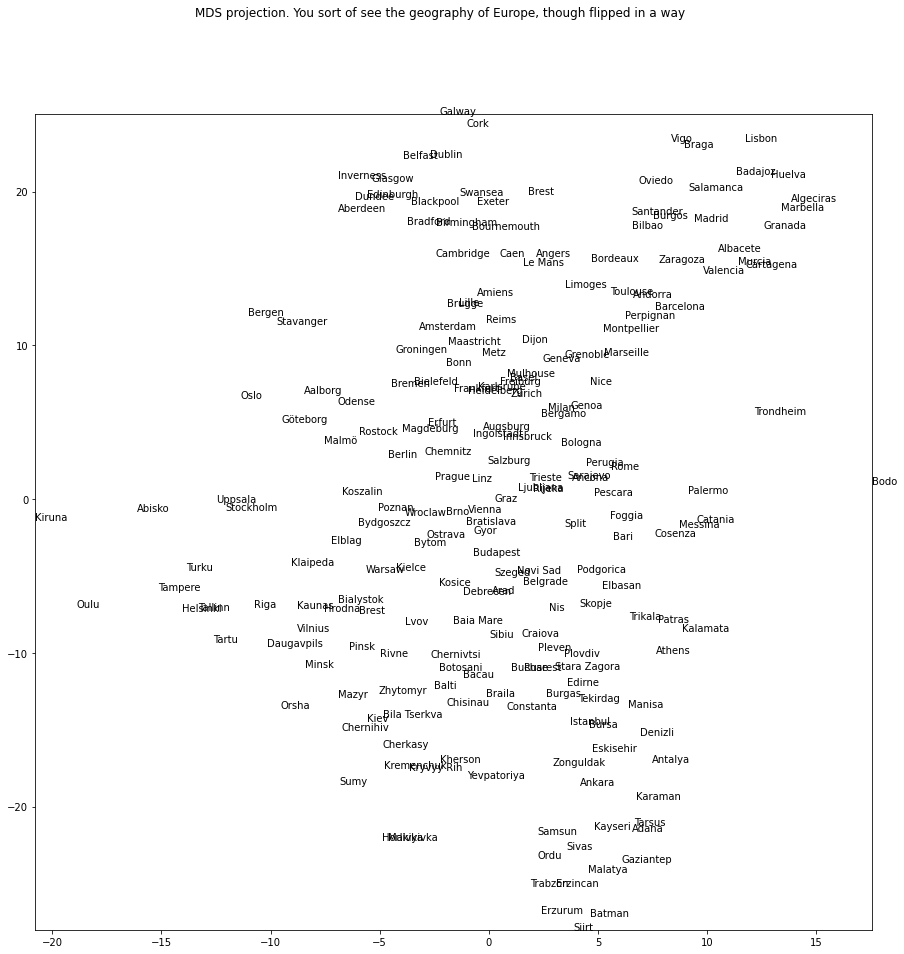

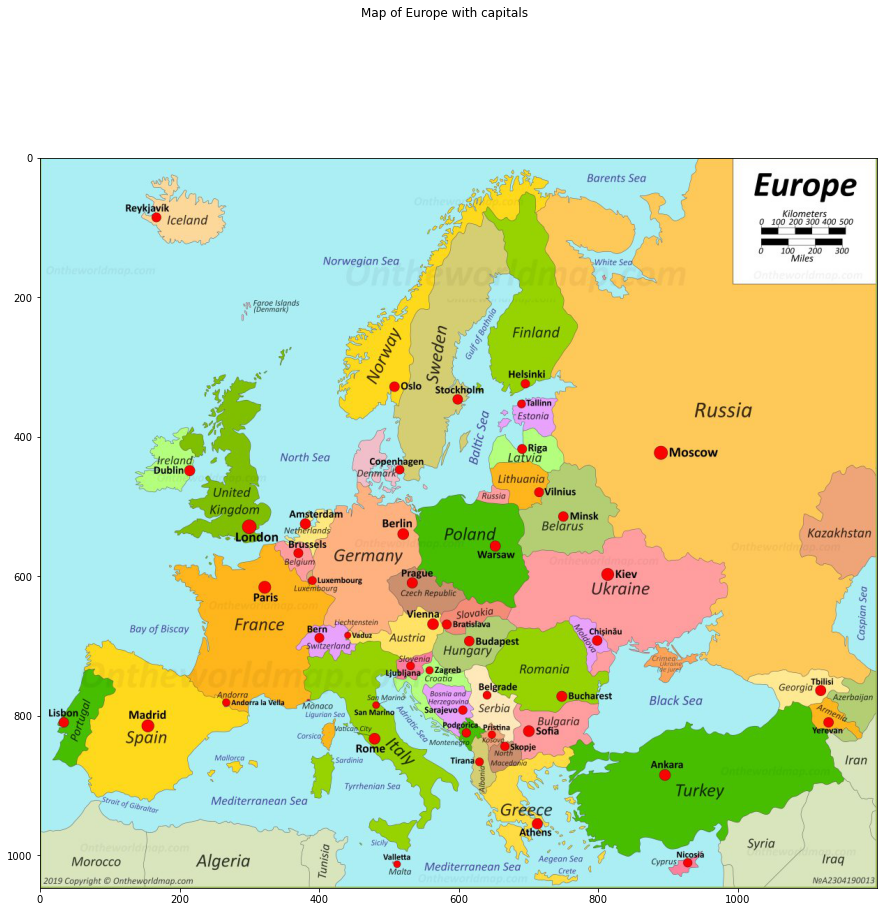

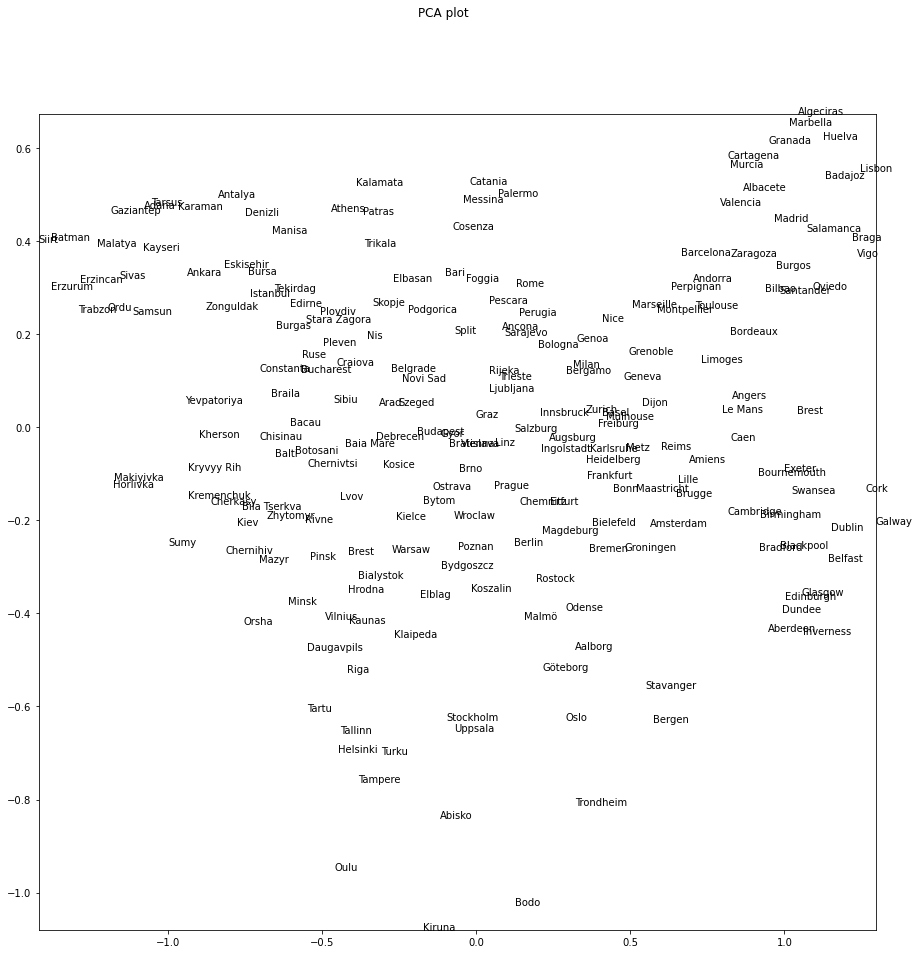

In [307]:
%matplotlib inline
cityDataEurope = pd.read_csv("Cities.csv")
display(cityDataEurope.head())
from sklearn.manifold import MDS

latLongDataOnly = cityDataEurope.iloc[:,2:4].to_numpy()
cityNames = cityDataEurope.loc[:,"city"].to_numpy()

embedding = MDS(n_components = 2)
embeddedCities = embedding.fit_transform(latLongDataOnly)

fig, ax = plt.subplots(figsize = (15,15))
ax.set_xlim((np.min(embeddedCities[:,0]), np.max(embeddedCities[:,0])))
ax.set_ylim((np.min(embeddedCities[:,1]), np.max(embeddedCities[:,1])))
for index, row in enumerate(embeddedCities):
    ax.annotate(cityNames[index], (row[0], row[1]))
fig.suptitle("MDS projection. You sort of see the geography of Europe, though flipped in a way")
fig.show()

fig,ax = plt.subplots(figsize = (15,15))
europeMap = plt.imread("map-of-europe-with-capitals.jpg")
fig.suptitle("Map of Europe with capitals")
ax.imshow(europeMap)
fig.show()
# your answer here

# answer 
latLongDataMean = np.mean(latLongDataOnly,axis = 0)
latLongDataStd  = np.std(latLongDataOnly)
normLocData     = (latLongDataOnly-latLongDataMean)/latLongDataStd
eigVal, EigVec, projData = doPCA(normLocData)

fig, ax = plt.subplots(figsize = (15,15))
for index, row in enumerate(projData):
    ax.annotate(cityNames[index], (row[0], row[1]))
ax.set_xlim((np.min(projData[:,0]), np.max(projData[:,0])))
ax.set_ylim((np.min(projData[:,1]), np.max(projData[:,1])))
fig.suptitle("PCA plot")
    


## What you see

It might not look it, but these are equivalent ways of showcasing the pairwise distances in two dimensions. A hint that they're the same is, for instance, that Graz is in the middle in both maps. Of course, it doesn't look like reality, but that's because we're doing this only based on distances or correlations, not on other properties, like how it relates to the rest of the world, or from which side we usually look at our map projections and find it logical to think about them.

Now PCA stays PCA, but for MDS we could make a map that shows something else. For example, say that you're a purist who only wants to travel in straight lines (we're assuming that the Earth is flat for now, emphasis on _assuming_ and not _believing_) in the 4 cardinal directions. Then we could use the L1 norm or absolute distance. Let's do that and see how close different cities are then:

<ipython-input-308-099c57fbc251>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


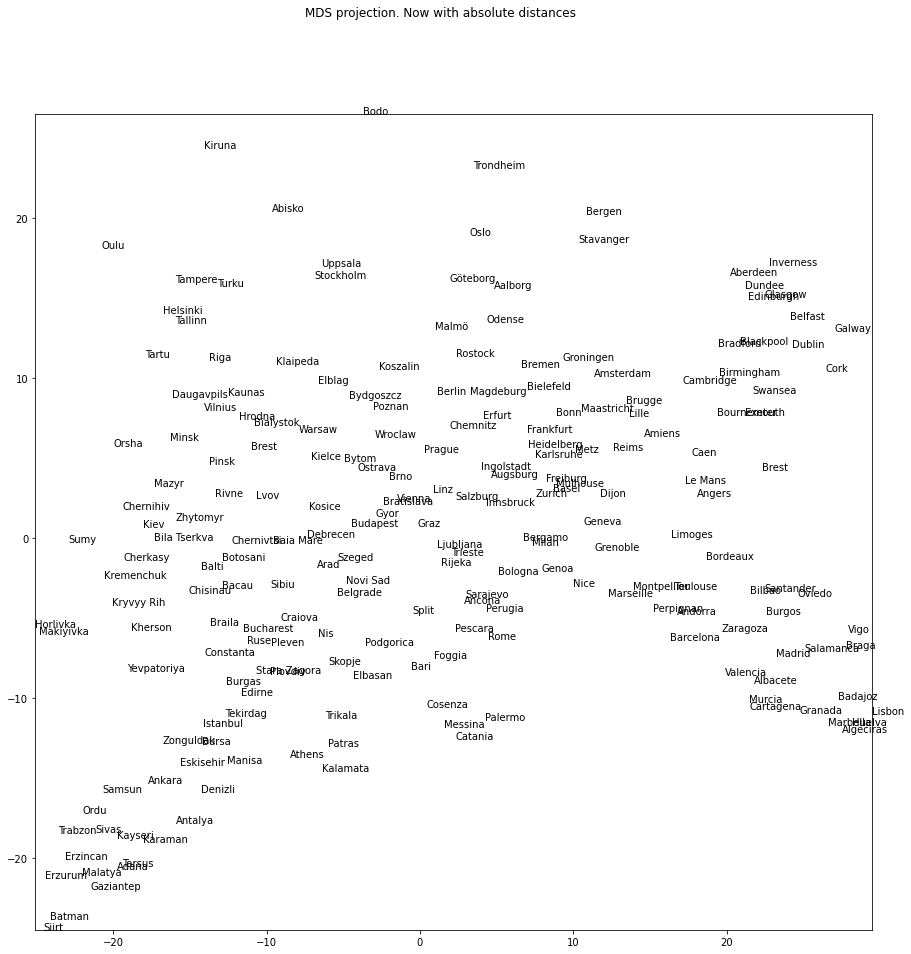

In [308]:
distMatEuropeCities = np.zeros(shape = (len(cityDataEurope), len(cityDataEurope)))
for rowIndex, colIndex in itertools.product(list(range(0,len(distMatEuropeCities))), repeat = 2):
    #print(latLongDataOnly[rowIndex,:][:,np.newaxis])
    distMatEuropeCities[rowIndex, colIndex] = calcAbsDist(latLongDataOnly[rowIndex,:][np.newaxis,:],
                                                            latLongDataOnly[colIndex,:][np.newaxis,:])
    
embeddingLOne = MDS(n_components = 2, dissimilarity='precomputed')
manhattanMDS  = embeddingLOne.fit_transform(distMatEuropeCities)

fig, ax = plt.subplots(figsize = (15,15))
ax.set_xlim((np.min(manhattanMDS[:,0]), np.max(manhattanMDS[:,0])))
ax.set_ylim((np.min(manhattanMDS[:,1]), np.max(manhattanMDS[:,1])))
for index, row in enumerate(manhattanMDS):
    ax.annotate(cityNames[index], (row[0], row[1]))
fig.suptitle("MDS projection. Now with absolute distances")
fig.show()
    


## Result

It looks somewhat different, but not too much. In the end, what you need to remember is that there are more (linear) methods than just PCA. PCA is or making uncorrelated dimensions that keep most variance, and so perfect for something like machine learning. MDS, on the other hand, is better when you want to make a projection to fewer dimensions that respects high-dimensional distances. The hot newcomer algorithm on the scene for that (which is non-linear) is [UMAP](https://pair-code.github.io/understanding-umap/), which we won't go into. Something else to look into might be [ivis](https://bering-ivis.readthedocs.io/en/latest/).

For now, however, let's return to PCA. 

## PCA and GWAS

In our mini-GWAS on Monday, I noted that there were many simplifications and liberties used. Not only did I add _very strong_ signal manually and trim the dataset drastically, I also had a dataset that included only people of European descent. For more power and/or generalisability, ideally you have samples from many ethnic groups. However, as you might imagine, this leads to issues: when we are looking at SNPs and their effect on BMI, if a certain subpopulation is overrepresented in _cases_ (i.e. people with high BMI), then we might get spurious hits: SNPs that are just more present in that subpopulation due to genetic ancestry, but have nothing to do with the condition. The text in box 4 from [this 2006 review paper](https://www.nature.com/articles/nrg1916) explains:

![PS](PopStruct.PNG)

What do we expect for these subgroups? They will have rather large variance in SNPs among them: it's logical that people from South America will, on average, differ quite a lot in alleles they have at SNP sites from people from North-East Russia or Japan. With PCA, we have in our hands a technique that can easily create the dimensions along which samples vary most. Do you see where I am going with this? If we perform PCA, and include the PCA in our linear regressions in addition to the value for the actual SNP at hand (something like $\theta_0 \cdot 1 + \theta_1 \cdot PC1 + \theta_2 \cdot PC2 + \theta_3 \cdot PC3 + \theta_4 \cdot PC4 + \theta_5 \cdot SNP_{count}$), then we can fit our linear regressions _while correcting for the dominant population structure in the data_. 

Of course, in that case we don't care about the magnitude of $\theta_1$ until $\theta_4$, we are still only interested in how the numerical trait (BMI) increases or decreases with the number of opposite alleles at a certain SNP location (0,1 or 2), which is $\theta_5$. But by including the other parameters, we can know that there's an effect of this SNP even when correcting for population structure. Newer methods may exist, so in real research situations you should search those out and/or use Plink. [Here](https://www.nature.com/articles/ng1847) is the 2006 paper that proposed this method of using PCs.

In fact, population stratification is a bit of a misnomer: this will happen also if you just sequence people from some village in the vicinity of Graz versus those in, say, Utrecht. Anytime there's this shared ancestry, that confounds the generality. So we should also use something to correct for that in a European population:

![image](popStructComment.png)

## Data provenance

I took the same data as I used on Monday, but rather than putting synthetic signal into random SNPs, I put signal into 20 real SNPs known to influence BMI and obesity, chief of which is the FTO gene. I got these top 20 SNPs from [a 2020 paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7720118/) analysing the applicability of SNPs found to influence BMI in the general European population (specifically, the Hungarian general population) to the Roma subpopulation in Hungary.

## Assignment

Below, I generate data that has signal in ~20 SNPs, out of ~200. It is up to you to:
* Eliminate NaNs using by setting them to have the reference allele (i.e. 0). 
* Perform PCA on the feature matrix of SNPs (`X`). Plot a PCA plot of the projection of all samples (people) into 2D. Label the axes with the %variance explained. Do there seem to be clumped subpopulations of people?
* Keep the 2 first principal components. You will use these as extra variables in your multivariate linear regression.
* Do the linear regression for each SNP and save the resulting thetas. Don't forget normalisation. You can use the function `linAlgGradientDescent(x, y, thetas, alpha)`. You should include the PCs in the feature matrix!
* Calculate the standard error and the p-value using the function supplied, order by magnitude (small to large) and see whether the top 14 SNPs you get are indeed the signal put in. Hopefully you should do slightly better than Monday because we are now correcting for some covariates (though not, unfortunately, for age or ...). However, if the population is very homogeneous, then that affect won't be there.

In [115]:
euroGWASData = read_plink1_bin("..\..\Day1\Practical\HapMap_3_r3_1.bed",
                               "..\..\Day1\Practical\HapMap_3_r3_1.bim",
                               "..\..\Day1\Practical\HapMap_3_r3_1.fam", verbose=True)

BMISNPs = pd.read_csv("TwentyTopBMIAssociatedSNPs.csv")
display(BMISNPs)

Mapping files: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.87s/it]


,SNP,Gene,Risk allele,Beta_HG,Std. Error_HG,p-value_HG,Beta_HR,Std. Error_HR,p-value_HR
0,rs10938397,GNPDA2,G,0.299,0.212,0.160,0.619,0.359,0.085
1,rs1121980,FTO,A,0.553,0.205,0.007,0.604,0.356,0.090
2,rs1137101,LEPR,G,0.099,0.212,0.639,-0.106,0.356,0.767
3,rs12970134,MC4R,A,0.368,0.240,0.126,0.066,0.421,0.875
4,rs1501299,ADIPOQ,T,0.049,0.231,0.832,0.354,0.387,0.360
5,rs1558902,FTO,A,0.482,0.205,0.019,0.628,0.360,0.081
6,rs16139,NPY,C,-0.602,0.517,0.244,-0.686,1.186,0.563
7,rs17782313,MC4R,C,0.320,0.247,0.194,0.179,0.422,0.672
8,rs1801282,PPAR?,C,-0.005,0.314,0.988,-1.188,0.807,0.141
9,rs2241766,ADIPOQ,G,-0.152,0.337,0.653,-0.473,0.553,0.392


In [155]:
random.seed(42)

#subsetting some columns
downsizedData = euroGWASData[:, random.sample(range(0, euroGWASData.shape[1]), 200)]
columnsWithoutVariation = np.all(downsizedData.values == downsizedData.values[0,:], axis = 0)
downsizedData = downsizedData[:, np.invert(columnsWithoutVariation)]

# add normally distributed BMI value with mean that is somewhat healthy 
newArray = np.zeros(len(downsizedData.trait))
downsizedDataNew = downsizedData.drop_vars("trait")
newArray = np.random.default_rng(seed = 42).normal(22.5, 1, len(newArray))

# SNPs to add signal to
BMISNPsInEuroData = np.where(np.isin(euroGWASData.snp, BMISNPs.SNP.values))[0]
subsetSNPsForSignal = euroGWASData[:, BMISNPsInEuroData]
print("SNP information Euro cohort for SNPs in the top 20 BMI-associated SNPs:")
display(subsetSNPsForSignal)

importantSNPsInSampleData = np.isin(BMISNPs.SNP.values, euroGWASData.snp)
BMISNPsSubsetInEuroData   = BMISNPs.iloc[importantSNPsInSampleData,:]
print("SNPs out of the top 20 that are in the data: ")
display(BMISNPsSubsetInEuroData)

#concatenate xarrays
downsizedDataNew = xarray.concat([downsizedDataNew, subsetSNPsForSignal], dim = "variant")

# add the signal
print("Original random BMI values:")
print(newArray)
for colIndex in range(0, subsetSNPsForSignal.shape[1]):
    currentSNPName = subsetSNPsForSignal[:,colIndex].snp
    SNPEffect   = BMISNPsSubsetInEuroData.loc[BMISNPsSubsetInEuroData.SNP == currentSNPName,["Beta_HG"]].values
    SNPEffect   = np.ravel(SNPEffect)
    twoAlleles  = np.where(subsetSNPsForSignal[:, colIndex].values == 2.)
    oneAllele   = np.where(subsetSNPsForSignal[:, colIndex].values == 1.)
    noMuts      = np.where(subsetSNPsForSignal[:, colIndex].values == 0.)
    newArray[twoAlleles] += np.random.default_rng().normal(SNPEffect*2, 0.1, len(twoAlleles))
    newArray[oneAllele]  += np.random.default_rng().normal(SNPEffect, 0.1, len(oneAllele))
downsizedDataNew["BMI"] = ("sample", newArray)
print("Final BMI values with SNP effects:")
print(downsizedDataNew["BMI"])

X = downsizedDataNew.values #the #SNPs each person has at each position, 165 people by ~192 SNPs
y = downsizedDataNew["BMI"].values # BMI values for each person, (165,) (1D-array)


# answers

#1. SNPs are just single nucleotides which are changed. They can lie in different enhancers that influence one gene,
#   be multiple positions in the same gene (or its introns that affect regulation), etc.
#
#2. rs1801282, PPAR?, is much more protective in the Roma subpopulation for some reason. 
#
#code: see below

SNP information Euro cohort for SNPs in the top 20 BMI-associated SNPs:


<xarray.DataArray 'genotype' (sample: 165, variant: 14)>
dask.array<getitem, shape=(165, 14), dtype=float32, chunksize=(165, 4), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object 'NA06989' 'NA11891' ... 'NA10854' 'NA12865'
  * variant  (variant) <U14 'variant37952' 'variant119841' ... 'variant1307268'
    fid      (sample) object '1328' '1377' '1349' ... '1375' '1349' '1459'
    iid      (sample) object 'NA06989' 'NA11891' ... 'NA10854' 'NA12865'
    father   (sample) object '0' '0' '0' '0' ... '0' '0' 'NA11839' 'NA12874'
    mother   (sample) object '0' '0' '0' '0' ... '0' '0' 'NA11840' 'NA12875'
    gender   (sample) object '2' '1' '1' '2' '1' '2' ... '2' '1' '1' '1' '2' '2'
    trait    (sample) object '2' '2' '1' '2' '-9' ... '-9' '2' '1' '-9' '-9'
    chrom    (variant) object '1' '2' '3' '3' '11' ... '16' '16' '16' '18' '18'
    snp      (variant) object 'rs2815752' 'rs2867125' ... 'rs12970134'
    cm       (variant) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pos      (variant) int32 72585028 612827 12368125 ... 56002077 56035730
    a0       (variant) object 'G' 'T' 'G' 'T' 'T' 'T' ... 'A' 'A' 'T' 'C' 'A'
    a1       (variant) object 'A' 'C' 'C' 'G' 'G' 'C' ... 'G' 'T' 'C' 'T' 'G'

SNPs out of the top 20 that are in the data: 


,SNP,Gene,Risk allele,Beta_HG,Std. Error_HG,p-value_HG,Beta_HR,Std. Error_HR,p-value_HR
1,rs1121980,FTO,A,0.553,0.205,0.007,0.604,0.356,0.090
3,rs12970134,MC4R,A,0.368,0.240,0.126,0.066,0.421,0.875
4,rs1501299,ADIPOQ,T,0.049,0.231,0.832,0.354,0.387,0.360
7,rs17782313,MC4R,C,0.320,0.247,0.194,0.179,0.422,0.672
8,rs1801282,PPAR?,C,-0.005,0.314,0.988,-1.188,0.807,0.141
10,rs2815752,NEGR1,C,0.289,0.222,0.193,-0.088,0.396,0.824
11,rs2867125,TMEM18,C,0.251,0.266,0.345,0.015,0.494,0.975
12,rs6265,BDNF,C,0.434,0.262,0.097,0.167,0.551,0.761
13,rs6499640,FTO,A,0.226,0.209,0.279,0.380,0.351,0.279
15,rs659366,UCP2,C,-0.049,0.219,0.821,0.402,0.369,0.277


Original random BMI values:
[22.80471708 21.46001589 23.2504512  23.44056472 20.54896481 21.19782049
 22.6278404  22.18375741 22.48319884 21.64695607 23.37939797 23.27779194
 22.5660307  23.62724121 22.96750934 21.64070754 22.86875078 21.5411174
 23.3784503  22.45007409 22.31513764 21.81907046 23.72254134 22.34547052
 22.07167218 22.14786645 23.03230919 22.86544406 22.91273261 22.930821
 24.6416476  22.09358498 21.98775727 21.68622727 23.11597942 23.62897229
 22.38605254 21.65984352 21.67551878 23.15059279 23.24325417 23.04315427
 21.83449029 22.73216132 22.61668581 22.7186886  23.37142878 22.72359555
 23.17891356 22.56757907 22.7891194  23.13128823 21.04284418 22.18032878
 22.02962735 21.86112215 22.22485775 23.99494131 21.63416888 23.46827835
 20.81713023 22.16511497 22.66275307 23.08622233 23.21122658 23.29334724
 22.15127493 22.03764821 23.35797588 22.30869568 21.22431368 21.36671279
 21.58054771 22.99716074 22.64242574 23.19048535 22.07274735 22.65853969
 23.12559039 22.19065346 2

## Below, write your code. Repeat of coding part of assignment:
Above, I have generated BMI values (`y`) and SNP counts (`X`). It is up to you to:
* Eliminate NaNs using by setting them to have the reference allele (i.e. 0). 
* Perform PCA on the feature matrix of SNPs (`X`). Plot a PCA plot of the projection of all samples (people) into 2D. Label the axes with the %variance explained. Do there seem to be clumped subpopulations of people?
* Keep the 2 first principal components. You will use these as extra variables in your multivariate linear regression.
* Do the linear regression for each SNP and save the resulting thetas. Don't forget normalisation. You can use the function `linAlgGradientDescent(x, y, thetas, alpha)`. You should include the PCs in the feature matrix!
* Calculate the standard error and the p-value using the function supplied, order by magnitude (small to large) and see whether the top 14 SNPs you get are indeed the signal put in. Hopefully you should do slightly better than Monday because we are now correcting for some covariates (though not, unfortunately, for age or ...). However, if the population is very homogeneous, then that affect won't be there.

Hints:
* `linAlgGradientDescent` uses `linAlgRegHypothesis`, which automatically appends a column of 1s to the front. So you don't need to do anything for $\theta_0$ to be correctly multiplied with 1.
* Take it in parts. First simply do the PCA like you did before. Then, make the features you'd need for 1 SNP to do the linear regression. Then implement this in the gradient descent loop (of which you are given a part) to actually perform it.
* When using the PCs as features, make sure to normalise them as well: they too should have unit variance and mean 0! (just use `(data - np.mean(data, axis = 0))/np.std(data, axis = 0)`).
* Look what you did on the afternoon of day 1. This is very similar. As always, if you're stuck, check the answers!

<IPython.core.display.Javascript object>


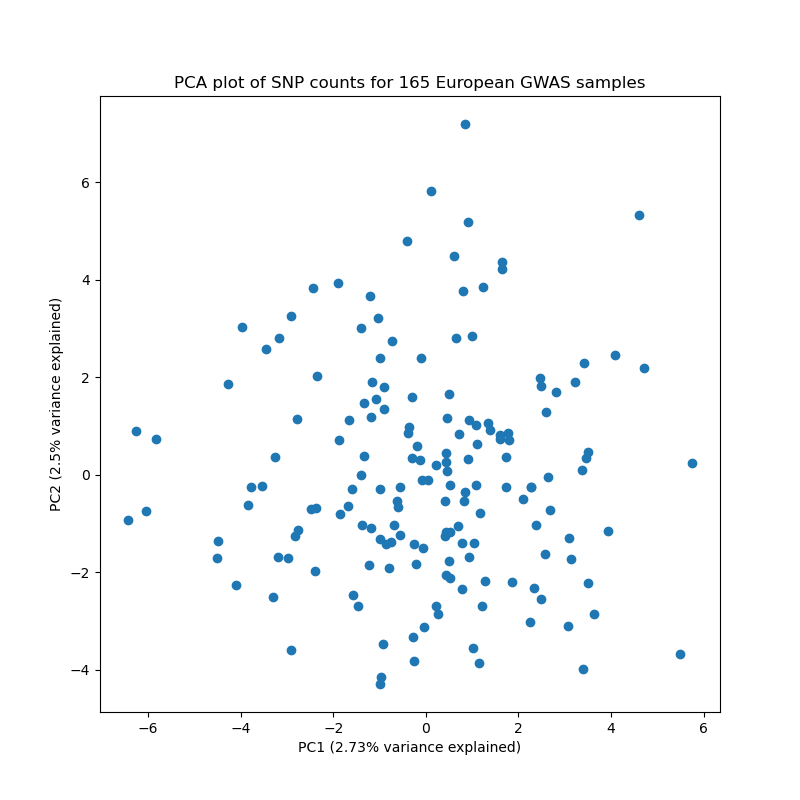

fitted parameters for each SNP:


,rs10417008,rs7578234,rs11166410,rs1508763,rs6452694,rs4364199,rs9614868,rs10141319,rs1584749,rs9674522,...,rs925946,rs6265,rs660339,rs659366,rs6499640,rs1121980,rs9939609,rs9941349,rs17782313,rs12970134
Theta0,-7.370586e-09,2.431252e-08,-8.235266e-10,2.931746e-09,1.303800e-08,6.320251e-10,1.402176e-09,2.238302e-09,3.293744e-09,-7.088401e-10,...,7.831478e-09,-4.933675e-10,1.703918e-08,9.359467e-09,3.241549e-09,-4.401694e-08,4.402545e-08,-3.688346e-08,7.662533e-09,1.533532e-08
Theta1,-8.820068e-02,1.317004e-01,1.184978e-02,4.586850e-02,-1.198550e-01,1.229367e-02,-6.751336e-02,-5.261057e-02,-7.091526e-02,-4.160845e-02,...,1.563013e-01,1.270772e-01,-1.929884e-01,-1.572109e-01,2.167203e-02,6.488849e-01,5.386422e-01,6.556511e-01,2.788031e-01,2.462132e-01
Theta2,5.356176e-01,5.264542e-01,5.288773e-01,5.410439e-01,5.392949e-01,5.266928e-01,5.327329e-01,5.424033e-01,5.445917e-01,5.294909e-01,...,5.741818e-01,5.134338e-01,5.522699e-01,5.475132e-01,5.338994e-01,4.329045e-02,1.314954e-01,2.404315e-02,5.275930e-01,5.323906e-01
Theta3,-6.639791e-02,-7.644687e-02,-8.425037e-02,-9.233941e-02,-1.002885e-01,-8.637629e-02,-8.290840e-02,-9.281826e-02,-8.542598e-02,-8.938663e-02,...,-1.258838e-01,-7.202697e-02,-1.390830e-01,-1.230794e-01,-8.864259e-02,-1.252104e-01,-9.597612e-02,-1.188150e-01,7.792083e-02,4.123659e-02


fitted parameters for each SNP with p-values for theta 1 (slope):


,rs10417008,rs7578234,rs11166410,rs1508763,rs6452694,rs4364199,rs9614868,rs10141319,rs1584749,rs9674522,...,rs925946,rs6265,rs660339,rs659366,rs6499640,rs1121980,rs9939609,rs9941349,rs17782313,rs12970134
Theta0,-7.370586e-09,2.431252e-08,-8.235266e-10,2.931746e-09,1.303800e-08,6.320251e-10,1.402176e-09,2.238302e-09,3.293744e-09,-7.088401e-10,...,7.831478e-09,-4.933675e-10,1.703918e-08,9.359467e-09,3.241549e-09,-4.401694e-08,4.402545e-08,-3.688346e-08,7.662533e-09,1.533532e-08
Theta1,-8.820068e-02,1.317004e-01,1.184978e-02,4.586850e-02,-1.198550e-01,1.229367e-02,-6.751336e-02,-5.261057e-02,-7.091526e-02,-4.160845e-02,...,1.563013e-01,1.270772e-01,-1.929884e-01,-1.572109e-01,2.167203e-02,6.488849e-01,5.386422e-01,6.556511e-01,2.788031e-01,2.462132e-01
Theta2,5.356176e-01,5.264542e-01,5.288773e-01,5.410439e-01,5.392949e-01,5.266928e-01,5.327329e-01,5.424033e-01,5.445917e-01,5.294909e-01,...,5.741818e-01,5.134338e-01,5.522699e-01,5.475132e-01,5.338994e-01,4.329045e-02,1.314954e-01,2.404315e-02,5.275930e-01,5.323906e-01
Theta3,-6.639791e-02,-7.644687e-02,-8.425037e-02,-9.233941e-02,-1.002885e-01,-8.637629e-02,-8.290840e-02,-9.281826e-02,-8.542598e-02,-8.938663e-02,...,-1.258838e-01,-7.202697e-02,-1.390830e-01,-1.230794e-01,-8.864259e-02,-1.252104e-01,-9.597612e-02,-1.188150e-01,7.792083e-02,4.123659e-02
pValTheta1,1.072567e-02,3.080231e-04,3.783232e-01,1.153459e-01,9.074135e-04,3.739181e-01,3.895949e-02,8.465797e-02,3.207357e-02,1.384037e-01,...,2.607275e-05,4.753968e-04,3.222741e-07,2.310203e-05,2.854660e-01,5.084485e-46,7.989771e-35,3.372762e-46,1.192710e-12,1.958091e-10


SNPs with 14 top p-values where signal was put in: 8


In [176]:
# note: since you'll be doing multivariate linear regression, you need to specify where in the theta vector
# the beta (slope) is. 
# For example, if you do your linear regression as:
# 1 * theta0 + SNPcount * theta1 + PC1 * theta2 + PC3 * theta3, then the posBeta should be 1.
# If you don't fill this in, you'll get p-values for the 2 PCs too. Also fine, just need to select the appropriate ones later.

X        = downsizedDataNew.values #the #SNPs each person has at each position, 165 people by ~192 SNPs
SNPNames = downsizedDataNew.snp.values # name for each column of X
y        = downsizedDataNew["BMI"].values # BMI values for each person, (165,) (1D-array)

def calcPValuesRegSlope(X, y, thetas, posBeta = None):
    """Skips calculation for the significance of the intercept (i.e. it being sig. different from 0,
    as it's the relation between BMI and the SNP we are interested in. Assumes theta as a vector (2D numpy array) of
    n_thetas by 1 (so 2 rows, 1 column for univariate linear regression)"""
    m = len(X)
    if posBeta is None:
        #calculate p-values for every theta except the intercept
        thetasToCalc = thetas[1:,:]
    else:
        thetasToCalc = thetas[posBeta,:]
    preds = linAlgRegHypothesis(X, thetas)
    #print(preds)
    #print(y)
    if not y.ndim > 1:
        y = y[:, np.newaxis]
    #print(X)

    sumSquareErrorsPred = np.sum(np.square(np.array(preds) - y))
    stdErrors = []; tStats = []; pVals = []
    for index, theta in enumerate(thetasToCalc):
        #print(theta) ;print(index)
        sumSquaresFeature = np.sum(np.square(X - np.mean(X)))
        stdError = np.sqrt((1/(m-2)) * (sumSquareErrorsPred/sumSquaresFeature))
        tStat    = (theta/stdError)[0]
        pVal     = scipy.stats.t.sf(abs(tStat), m-1)
        stdErrors.append(stdError); tStats.append(tStat); pVals.append(pVal)
    #print(stdErrors)
    #print(tStats)
    #print(pVals)
    df = pd.DataFrame(np.vstack([stdErrors, tStats, pVals]))
    df.set_index(pd.Index(["standard errors", "t statistics", "p-values"]), inplace = True)
    return[pVals, df]





# your answer here




# start for fitting the data with linear regression
startThetas = np.array([[0], [0], [0], [0]])
nSteps      = 30
#Normalise the outcome measure!

alpha       = 0.3 
listThetasForEachSNP = []

for SNPIndex in range(0, X.shape[1]):
    
    valsThisSNP = X[:, SNPIndex]

    currentThetas = startThetas
    for step in range(0, nSteps):
        #do something
        break
    break


# answer

#remove NaNs
X[np.isnan(X)] = 0

# normalise 
meanSNPs      = np.mean(X, axis = 0)
stdSNPs       = np.std(X, axis = 0)
normSNPCounts = (X-meanSNPs)/stdSNPs
meanBMI       = np.mean(y)
stdBMI        = np.std(y)
normBMI       = (y-meanBMI)/stdBMI

# perform PCA and reduce dims
eigValSNP, eigVecSNP, projDataSNP = doPCA(normSNPCounts)
projDataSNPRed, eigVecRed = dimReducePCA(projDataSNP, eigVecSNP, nDims = 2)

# get % variance explained
varExplained = [elem/np.sum(eigValSNP)*100 for elem in eigValSNP]

# make PCA plot
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(projDataSNPRed[:,0], projDataSNPRed[:,1])
ax.set_xlabel("PC1 (" + str(np.round(varExplained[0], 2)) + "% variance explained)")
ax.set_ylabel("PC2 (" + str(np.round(varExplained[1], 2)) + "% variance explained)")
ax.set_title("PCA plot of SNP counts for 165 European GWAS samples")
fig.show()

# Note on plot:
# There's not really separate subclusters, but there are some clear outliers. You see that the ethnic heterogeneity is low:
# only small percentages of variance are explained on each axis.

# normalise the PCs
meanPCs = np.mean(projDataSNPRed, axis = 0)
stdPCs  = np.std(projDataSNPRed, axis = 0)
normPCs = (projDataSNPRed-meanPCs)/stdPCs


for SNPIndex in range(0, X.shape[1]):
    
    valsThisSNP = normSNPCounts[:, SNPIndex]
    valsThisSNP = np.c_[valsThisSNP, normPCs]
    currentThetas = startThetas
    for step in range(0, nSteps):
        newThetas     = linAlgGradientDescent(valsThisSNP, normBMI, currentThetas, alpha)
        currentThetas = newThetas
    listThetasForEachSNP.append(currentThetas)

    
# showcase the thetas we get for each SNP
thetasTogether  = np.hstack(listThetasForEachSNP)
dataFrameThetas = pd.DataFrame(thetasTogether)
dataFrameThetas.columns = SNPNames
dataFrameThetas.set_index(pd.Index(["Theta0", "Theta1", "Theta2", "Theta3"]), inplace = True)
print("fitted parameters for each SNP:")
display(dataFrameThetas)

# get p-values
pValsPerSNP = []; listDFs = []
for SNPindex, thetas in enumerate(listThetasForEachSNP):
    pVal, dfInfo = calcPValuesRegSlope(np.c_[normSNPCounts[:, SNPindex], normPCs], normBMI, thetas)
    pValsPerSNP.append(pVal)
    listDFs.append(dfInfo)

# we're only really interested in the p-values for the slopes. For me that is theta 1, which is the first element of 
# the pVal list you get as output from calcPValuesRegSlope

pValSlopesOnly = [pValList[0] for pValList in pValsPerSNP]
addPValsToDf   = pd.DataFrame(np.array(pValSlopesOnly)[np.newaxis,:]); addPValsToDf.columns = SNPNames; addPValsToDf.set_index(pd.Index(["pValTheta1"]), inplace = True)
print("fitted parameters for each SNP with p-values for theta 1 (slope):")
display(dataFrameThetas.append(addPValsToDf))

# You'll see there's a lot of spurious hits. You would expect something like 24 'significant' p-values, but there's 68 (for me).
# I don't know why this is, exactly. It's not important for now: in reality only very significant hits are taken into account
# in GWAS. So let's look at the top 14 ones.

indicesTopFourteenContenders = np.argsort(np.array(pValSlopesOnly))[0:14]
print("SNPs with 14 top p-values where signal was put in: " + str(np.sum(np.in1d(SNPNames[indicesTopFourteenContenders], BMISNPsSubsetInEuroData.SNP.values))))


## Results

In the end, you don't perform _that_ much better, or perhaps not even better at all because in this small sample data the effect of population genotypic variation/clustering due to shared descent in different groups is not strong at all. However, what you _have_ done is combined your knowledge of gradient descent, linear regression, and unsupervised learning to make a more methodically sound (although, on the whole, still  _a good deal less sound_ than real GWAS studies, it needs be said) GWAS analysis of SNPs influencing BMI.

Of course, PCA has many more uses in the ML context rather than only removing covariates in GWAS. Its chief use is decreasing dimensionality, as you have seen. This is a very important function, guarding against overfitting, and making visualisations possible. In fact, more advanced tools like t-SNE and UMAP can benefit from first reducing the dimensionality to, say, 100 dimensions using PCA, and _then_ using them. PCA is not outdated! For a nice slide deck on PCA, t-SNE and UMAP, see [here](https://www.bioinformatics.babraham.ac.uk/training/10XRNASeq/Dimension%20Reduction.pdf).

## What I'd like you to remember here
* That clustering can also be used for compression, particularly of images. However, you could also imagine data that is, for your purposes, pretty well described by just the values for 20 clusters of points, rather than the full feature matrix of 100 features for 1000 samples each, let's say. This is a relatively minor point though. The real star is:
* How PCA works: normalising data, calculating the covariance matrix, rotating the full data to new axes which are linear combinations of the old dimensions. This minimises the projection error, and maximises the variance in each axis. Under the hood, this is done with eigenvectors and eigenvalues, or SVD.
* That a user can then subselect any number of dimensions he or she wishes to keep, often using a cut-off of a certain % of variance kept in the data.
* That the eigenvectors (also called loadings) inform you how much the values on each of the original dimensions contribute to the values on the new PCA axes. Features with high values here are worth looking into: apparently it's variance in them that mostly define certain PCs, so you might be able to get insights into your data!
* That MDS is something that, you know, _exists_, and that its slight twist on PCA is that it works on a distance matrix, which allows you to use different distances that are then best preserved in lower dimensions (rather than just focussing on getting the linearly independent axes that hold most of the variance as in PCA). You could imagine that there's many different distance measures you could use between the gene expressions of 2 cells, and each would result in a different MDS plot (that can give you a different look at your data). 
* The nice possible use of PCA in GWAS (though there are other methods). GWAS focuses on many independent linear regressions (or logistic regressions for things like obese/not obese) on extremely large cohorts of people, with cases and controls. If some cases are more related, and have had similar _environmental_ exposure that caused increases in BMI (say unhealthy eating habits) that could cause spurious associations of SNPs they share with BMI. PCA, by catching the largest variations, can be used to correct for the largest variations, which are caused by changes in ancestry, removing these spurious hits.

## The end

Wow, you survived for a whole week. Given that you make about 2-3 million red blood cells per second, you went and generated between 865 and 1259 billion red blood cells during this time. Way to go! Compared to that, the achievement of learning quite a lot about ML seems somewhat minor. But you did that at _the same time_. Go you!

As you all know, after preppyness comes the deathly serious task of filling out the

## Survey
That's right, [get it while it's hot!](https://docs.google.com/forms/d/e/1FAIpQLSfJpOWtftiPXv_Q6QpaLZ6BVt3aE5DD1MuxBCXM11mPyyxrSA/viewform?usp=sf_link)